# Análise utilizando os autovalores da matriz Laplaciana

O segundo menor autovalor da matriz Laplaciana do grafo também é chamado de conectividade algébrica e possui propriedades interessantes sobre a conectividade do grafo. Ao invés de considerar apenas o segundo menor, podemos considerar um range $[2,...]$ para uma representação de maior dimensão para cada grafo

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
import time
import torch
import pickle
import parkinson
import optuna

import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from joblib import Parallel, delayed
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler

/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
RDN = 42
N_CLASSES = 2
BATCH_SIZE = 1
N_EPOCHS = 200
PATIENCE = 20
LR = 0.00001

## Processamento dos dados

In [6]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 
prodomal_data =  parkinson.utils.data.batch_read('../data/Prodomals_columns') 

100%|██████████| 188/188 [00:09<00:00, 18.89it/s]


Checando as colunas que aparecem no dataset Control para Shen_268 e renomeando

In [7]:
for i in range(len(control_data)):
    df = control_data[i]
    replace_dict = {
        column: column.replace('shen-268', 'Shen_268').replace('shen 268', 'Shen_268').replace('Shen-268', 'Shen_268')
        for column in df.columns
    }
    control_data[i] = df.rename(columns=replace_dict)

Selecionando o Atlas AAL3

In [8]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

## Pearson + Threshold Continuo

In [9]:
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data, return_upper_triangular=False)
control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data, return_upper_triangular=False)
prodomal_correlation_matrix = parkinson.utils.correlation.pearson_correlation(prodomal_atlas_data, return_upper_triangular=False)

In [10]:
def get_sparse_adjacency_matrix(correlation_matrix: np.array, threshold: float = 0.01):
    a = correlation_matrix.copy()
    N = len(a)
    a[np.abs(a) < threshold] = 0
    a[np.abs(a) > threshold] = 1
    a -= np.eye(N)
    return sp.sparse.csr_matrix(a)

In [11]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
y_2class = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [1 for _ in range(len(prodomal_data))])
correlation_matrices, y_2class = parkinson.utils.data.filter_data(correlation_matrices, y_2class)

In [12]:
def get_continuous_connectivity(correlation_matrices: list[np.array]) -> list[np.array]:
    threshold_list = np.arange(0.1, 0.35, 0.025)

    continuous_graph_connectivity = []

    for threshold in tqdm(threshold_list):
        connectivity_graphs = [
            get_sparse_adjacency_matrix(matrix, threshold=threshold) for matrix in correlation_matrices
        ]

        graph_laplacians = [
            sp.sparse.csgraph.laplacian(matrix, normed=True)
            for matrix in connectivity_graphs
        ]

        graph_connectivity = [
            sp.sparse.linalg.eigs(laplacian, which='SR', k=2)[0][1].real
            for laplacian in tqdm(graph_laplacians)
        ]

        continuous_graph_connectivity.append(graph_connectivity)

    return np.array(continuous_graph_connectivity).T

In [13]:
continuous_graph_connectivity = get_continuous_connectivity(correlation_matrices)

100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


### Classificação

In [16]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(continuous_graph_connectivity, y_2class, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

#### Resampling

In [17]:
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

X_train, y_train = ros.fit_resample(X_train, y_train)

In [18]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([272, 272]))

In [22]:
optimized_params = {'C': 0.01, 'coef0': -1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}

classifier = SVC(random_state=RDN)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
classifier.predict(X_test)

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1])

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.38      0.25        13
           1       0.85      0.68      0.76        69

    accuracy                           0.63        82
   macro avg       0.52      0.53      0.50        82
weighted avg       0.75      0.63      0.68        82



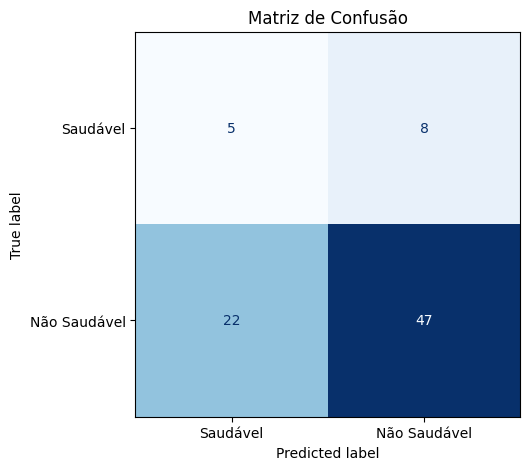

In [24]:
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Saudável', 'Não Saudável'])

### Otimização de Hiperparametros com Optuna

In [19]:
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.

    C = trial.suggest_float('C', 1e-10, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 1, 7)
    coef0 = trial.suggest_int('coef0', -10, 10)

    classifier = SVC(
        gamma=gamma,
        degree=degree,
        coef0=coef0,
        kernel='poly',
        C=C,
        random_state=RDN
    )

    scores = np.mean(cross_val_score(classifier, X=X_train, y=y_train, cv=10, scoring='f1_weighted'))

    return scores

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-07-04 15:42:33,152] A new study created in memory with name: no-name-a12b285d-f5df-4da0-839b-1872c3d23c7f
[I 2025-07-04 15:42:33,281] Trial 0 finished with value: 0.4633375092689766 and parameters: {'C': 0.04005346239968044, 'gamma': 'scale', 'degree': 7, 'coef0': -3}. Best is trial 0 with value: 0.4633375092689766.


In [ ]:
best_params = study.best_params
best_params

{'C': 10.51255459790409, 'gamma': 'scale', 'degree': 4, 'coef0': 6}

In [ ]:
classifier = SVC( **best_params)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

              precision    recall  f1-score   support

           0       0.40      0.31      0.35        13
           1       0.88      0.91      0.89        69

    accuracy                           0.82        82
   macro avg       0.64      0.61      0.62        82
weighted avg       0.80      0.82      0.81        82



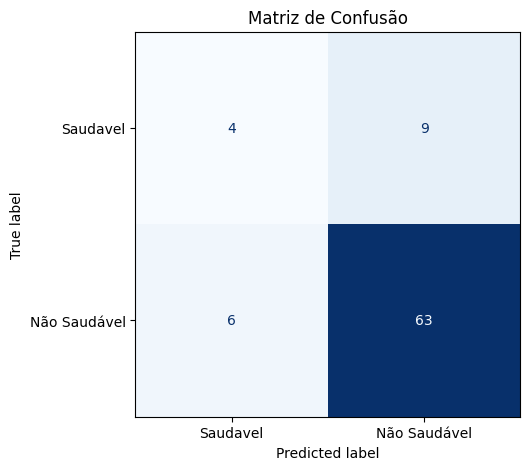

In [ ]:
print(classification_report(y_test, y_pred))
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Saudavel','Não Saudável'])

## Redes Neurais

In [14]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_trainval, X_test, y_trainval, y_test = train_test_split(continuous_graph_connectivity, y_2class, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

# Aplicando oversampling no conjunto de treino
ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Criando DataLoaders
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [17]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=X_train.shape[1], hidden_dim=10, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR,
    path="../weights/4_laplacian_2step"
)

metrics = parkinson.utils.train.evaluate(model, test_loader, device, path="../weights/4_laplacian_2step")

train-loss: 0.7002  train-acc: 0.5000 | val-loss: 0.6192  val-acc: 0.8415:  10%|█         | 20/200 [00:36<05:31,  1.84s/it]

Early stopping at epoch 21


CPU times: user 21.1 s, sys: 7.69 s, total: 28.8 s
Wall time: 37.2 s


/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Acurácia      F1  Precisão   Recall
 0.841463 0.76902  0.708061 0.841463


/tmp/ipykernel_23785/2479595963.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
/tmp/ipykernel_23785/2479595963.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cf.show()


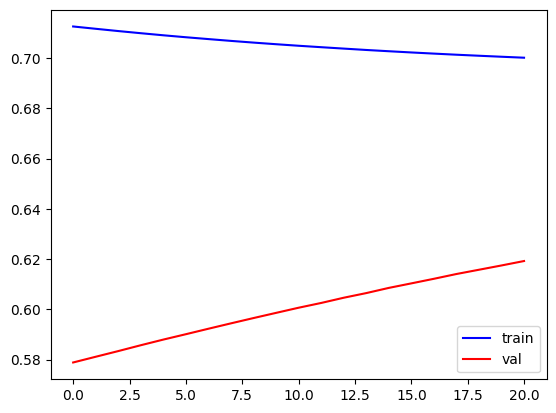

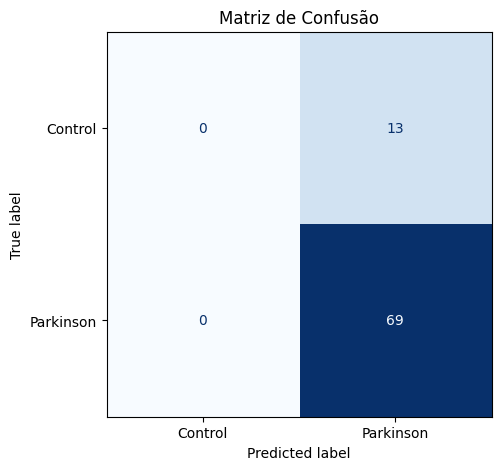

In [18]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])
fig_cf.show()